In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn import metrics
import os
import re
from wordcloud import WordCloud

In [2]:
# os.chdir('../../..')

In [3]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
data.rename(columns=dict(v1="label", v2="text"), inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data['text_processed'] = data['text'].map(lambda x: re.sub('[,\.!?]', '', x))
data['text_processed'] = data['text_processed'].map(lambda x: x.lower())
data.head()

,label,text,text_processed
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...


In [6]:
train = data.loc[:(int(0.8*len(data)))]
test = data.loc[(int(0.8*len(data))):]

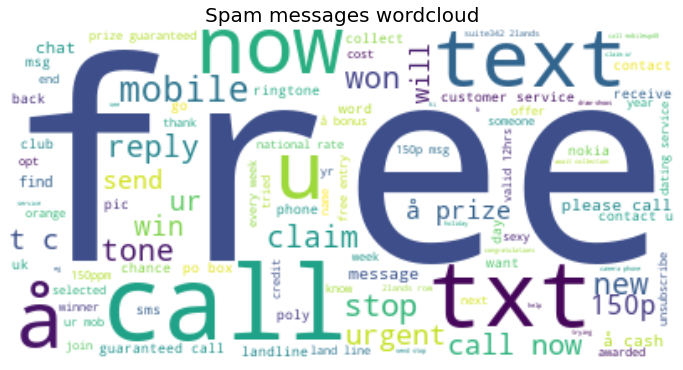

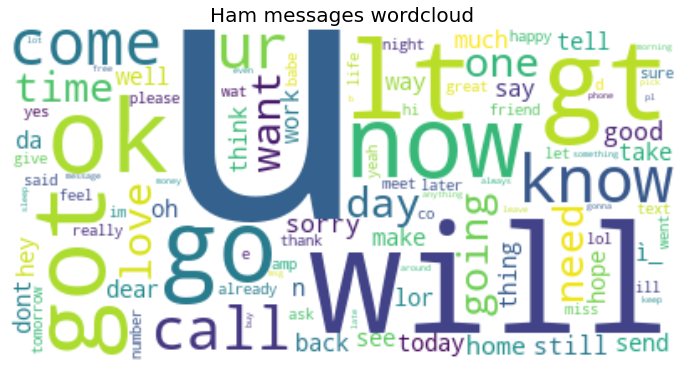

In [7]:
def text_for_cloud(label):
    text = ' '.join(train['text_processed'][train['label'] == label].to_list())
    text = text.replace('somenumbers', '')
    return text

for label in ['spam', 'ham']:
    wordcloud = WordCloud(
        max_font_size=500,
        max_words=100,
        background_color="white"
    ).generate(text_for_cloud(label))

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{label.capitalize()} messages wordcloud', fontsize=20)
    plt.show()

In [8]:
vectorizer = CountVectorizer(stop_words="english", 
                             ngram_range=(1, 3))
term_document_matrix = vectorizer.fit_transform(train.text_processed)
corpus = Sparse2Corpus(term_document_matrix, documents_columns=False)
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
model = LdaModel(corpus=corpus, 
                 id2word=id2word, 
                 random_state=0)

def transform_text_to_topic_vectors(data, vectorizer, model):
    num_topics = model.num_topics
    text_topics = pd.DataFrame(index=map(str, range(num_topics)))    
    for index, text in data.text_processed.iteritems():
        text_transformed = (vectorizer.transform([text]))
        text_corpus = (Sparse2Corpus(text_transformed, documents_columns=False))
        topics_framework = dict.fromkeys(map(str, range(0, num_topics)))
        topics_specific = dict(list(model[text_corpus])[0])
        for key in topics_specific:
            topics_framework[str(key)] = topics_specific[key]
        text_topics[index] = pd.Series(topics_framework)
    text_topics = text_topics.T.fillna(0)
    data = data.join(text_topics)
    data.drop(["text", "text_processed"], axis=1, inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    data.rename(columns=dict(Class_spam="Spam"), inplace=True)
    return data

train = transform_text_to_topic_vectors(train, vectorizer, model)
test = transform_text_to_topic_vectors(test, vectorizer, model)
train.head()

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)
C:\Users\avitr\AppData\Local\Temp\ipykernel_20448\747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label_spam
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.026174,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0


C:\Users\avitr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


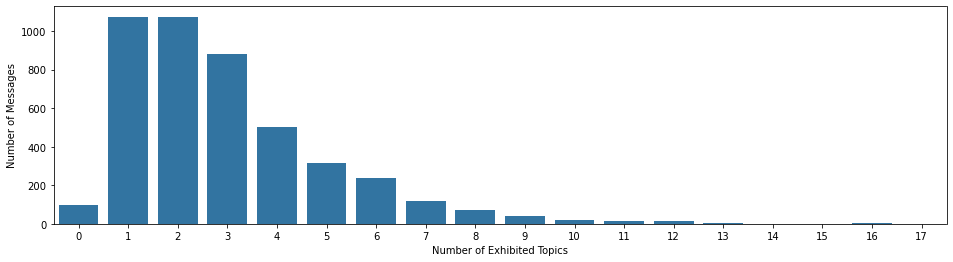

In [9]:
topics = list(train.columns)
topics.remove("label_spam")
ax = sns.countplot(train[topics].astype(bool).sum(axis=1), color="C0")
ax.set_xlabel("Number of Exhibited Topics")
ax.set_ylabel("Number of Messages")
fig = plt.gcf()
fig.set_size_inches(16, 4)

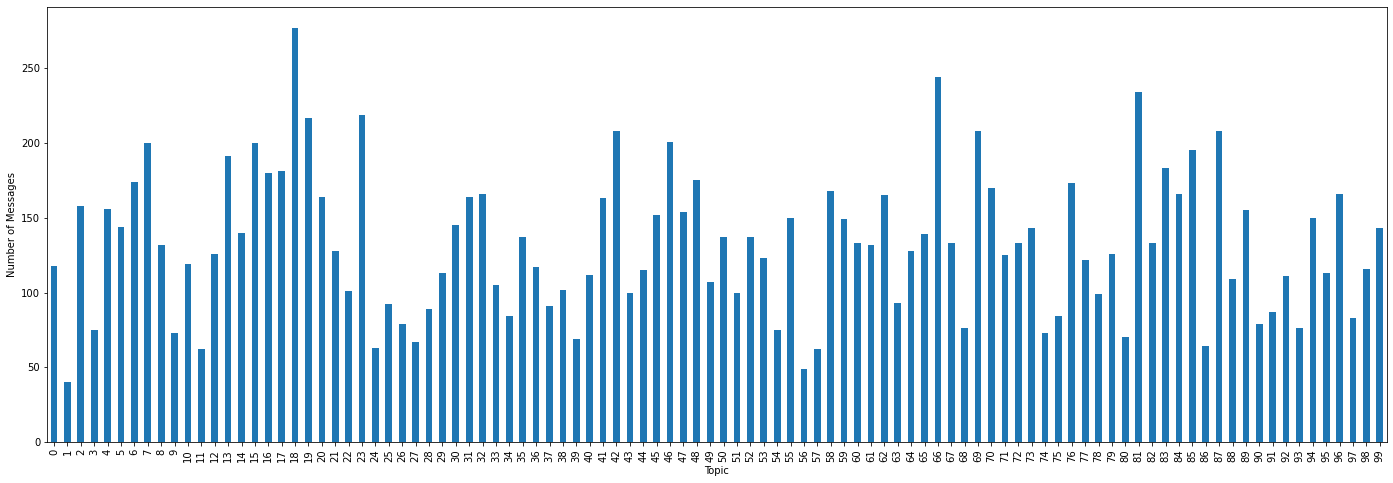

In [10]:
ax = train[topics].astype(bool).sum(axis=0).plot.bar(color="C0")
ax.set_xlabel("Topic")
ax.set_ylabel("Number of Messages")
fig = plt.gcf()
fig.set_size_inches(24, 8)

In [11]:
print("The most prevalent ngrams in the most prevalent topic are:\n- {}".format('\n- '.join([id2word[term[0]] for term in model.get_topic_terms(18)])))

The most prevalent ngrams in the most prevalent topic are:
- ì_
- wat
- time
- home
- wen
- ìï
- lar
- come
- wat time
- stuff


Topic 18 seems to be mostly used for organisation of meetings between the two texters.

C:\Users\avitr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label_spam', ylabel='count'>

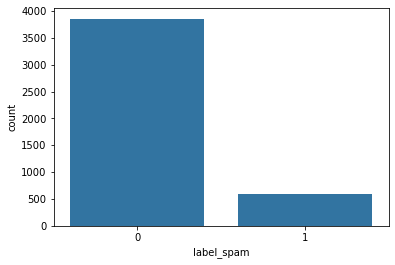

In [12]:
X_train = train.drop("label_spam", axis=1)
Y_train = train.label_spam
X_test = test.drop("label_spam", axis=1)
Y_test = test.label_spam
sns.countplot(Y_train, color="C0")

In [13]:
print("Number of spam messages in the test set: {}"\
      .format(test["label_spam"].value_counts()[1]))

Number of spam messages in the test set: 145


In [14]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

# QDA

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [17]:
clf_qda = QDA().fit(X_train,Y_train)

C:\Users\avitr\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [18]:
y_pred = clf_qda.predict(X_test)

In [21]:
Y_test.value_counts()

0    970
1    145
Name: label_spam, dtype: int64

In [19]:
print(metrics.classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.46      0.63       970
           1       0.20      0.93      0.34       145

    accuracy                           0.52      1115
   macro avg       0.59      0.70      0.48      1115
weighted avg       0.88      0.52      0.59      1115



SVM Linear:

In [15]:
%%capture --no-stdout

param_grid = dict(C=np.logspace(-3, 3, 7))
best_C_linear = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0), 
                             param_grid, 
                             cv=5).fit(X_train, Y_train)\
                                  .best_params_["C"]
print("The best value for the tuning parameter 'C' is {}.".format(best_C_linear))

The best value for the tuning parameter 'C' is 100.0.


In [16]:
svm_linear = LinearSVC(C=best_C_linear, 
                       random_state=0, 
                       max_iter=1e6).fit(X_train, Y_train)

svm_linear.score(X_test, Y_test)

C:\Users\avitr\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8932735426008969

In [17]:
SVM:

SyntaxError: invalid syntax (2010839389.py, line 1)

In [ ]:
%%capture --no-stdout

param_grid["gamma"] = ["auto", "scale"]
best_svm_rbf_params = GridSearchCV(SVC(class_weight="balanced", 
                                       random_state=0, 
                                       max_iter=1000), 
                                   param_grid, 
                                   cv=5).fit(X_train, Y_train)\
                                        .best_params_
print("The best value for the tuning parameter 'C' is {}."\
      .format(best_svm_rbf_params["C"]))
print("The best value for 'gamma' is {}.".format(best_svm_rbf_params["gamma"]))

In [ ]:
svm_rbf = SVC(C=best_svm_rbf_params["C"], 
              gamma=best_svm_rbf_params["gamma"], 
              random_state=0, 
              max_iter=-1).fit(X_train, Y_train)

In [ ]:
svm_rbf.score(X_test, Y_test)

Three version of Naïve Bayes (Gaussian with topic modeling and Multinomial and Complement without topic modeling):

In [ ]:
priors = list(train.label_spam.value_counts().div(train.label_spam.value_counts().sum()))
gnb = GaussianNB(priors).fit(X_train, Y_train)

In [ ]:
gnb.score(X_test, Y_test)

In [ ]:
# Need to make new set of X and Y train and test split for Multinomial Naïve Bayes without topic modelling.
from sklearn.model_selection import train_test_split

data_v2 = pd.read_csv("C:/Users/Koen-PC/Desktop/Actueel school/text mining/spam.csv", encoding="latin-1")
data_v2.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
data_v2.rename(columns=dict(v1="label", v2="text"), inplace=True)
data_v2['label_num'] = data_v2.label.map({'ham':0, 'spam':1})
data_v2['text_processed'] = data_v2['text'].map(lambda x: re.sub('[,\.!?]', '', x))
data_v2['text_processed'] = data_v2['text_processed'].map(lambda x: x.lower())
data_v2.head()

In [ ]:
X_train_v2, X_test_v2, Y_train_v2, Y_test_v2 = train_test_split(data_v2.text_processed, data_v2.label_num, test_size = 0.20, random_state=0)

In [ ]:
vect = CountVectorizer()

vect.fit(X_train_v2)

X_train_v2_dtm = vect.transform(X_train_v2)

X_train_v2_dtm = vect.fit_transform(X_train_v2)

# examine the document-term matrix
X_train_v2_dtm

# 4. transform testing data (using fitted vocabulary) into a document-term matrix
X_test_v2_dtm = vect.transform(X_test_v2)
X_test_v2_dtm


In [ ]:
mnb = MultinomialNB().fit(X_train_v2_dtm, Y_train_v2)
cnb = ComplementNB().fit(X_train_v2_dtm, Y_train_v2)

In [ ]:
mnb.score(X_test_v2_dtm, Y_test_v2)

In [ ]:
cnb.score(X_test_v2_dtm, Y_test_v2)

Ensemble Voting Classifier:

In [ ]:
classifiers = [("svm_linear", svm_linear), 
               ("gnb", gnb), 
               ("svm_rbf", svm_rbf)]
ensemble = VotingClassifier(classifiers).fit(X_train, Y_train)

In [ ]:
ensemble.score(X_test, Y_test)

In [ ]:
svm_linear_preds = svm_linear.predict(X_test)
gnb_preds = gnb.predict(X_test)
svm_rbf_preds = svm_rbf.predict(X_test)
ensemble_preds = ensemble.predict(X_test)

svm_linear_score = average_precision_score(Y_test, svm_linear_preds)
gnb_score = average_precision_score(Y_test, gnb_preds)
svm_rbf_score = average_precision_score(Y_test, svm_rbf_preds)
ensemble_score = average_precision_score(Y_test, ensemble_preds)

In [ ]:
print("The linear SVM has a test average precision score of {:.3f}.".format(svm_linear_score))
print("The Gaussian naive Bayes classifer has a test average precision score of {:.3f}."\
      .format(gnb_score))
print("The SVM with an RBF kernel has a test average precision score of {:.3f}."\
      .format(svm_rbf_score))
print("The ensemble voting classifier has a test average precision score of {:.3f}."\
      .format(ensemble_score))

In [ ]:
confusion = pd.DataFrame(confusion_matrix(Y_test, ensemble_preds))
confusion = confusion.div(confusion.sum().sum())
confusion.columns = ["Predicted Negative", "Predicted Positive"]
confusion.index = ["Actual Negative", "Actual Positive"]
ax = sns.heatmap(confusion, vmin=0, vmax=1, annot=True, fmt=".0%")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.collections[0].colorbar.set_ticks((0, .25, .5, .75, 1))
ax.collections[0].colorbar.set_ticklabels(("0%", "25%", "50%", "75%", "100%"))

In [ ]:
mnb_preds = mnb.predict(X_test_v2_dtm)
cnb_preds = cnb.predict(X_test_v2_dtm)

mnb_score = average_precision_score(Y_test_v2, mnb_preds)
cnb_score = average_precision_score(Y_test_v2, cnb_preds)

print("The Multinomial naive Bayes classifer has a test average precision score of {:.3f}."\
      .format(mnb_score))
print("The Complement naive Bayes classifer has a test average precision score of {:.3f}."\
      .format(cnb_score))

In [ ]:
print(metrics.classification_report(Y_test_v2, mnb_preds))

In [ ]:
print(metrics.classification_report(Y_test, ensemble_preds))